In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict

In [2]:
news = pd.read_csv('Sample data/train/news.tsv', sep='\t',header=None,  usecols=[0, 1, 2])
news.columns = ['nID', 'label', 'sub_label']
news = news.set_index('nID')
news.head()

,label,sub_label
nID,,
N55528,lifestyle,lifestyleroyals
N19639,health,weightloss
N61837,news,newsworld
N53526,health,voices
N38324,health,medical


In [3]:
newsLabels = {}

for index, row in news.iterrows():
    newsLabels[index] = (row['label'], row['sub_label'])

In [4]:
interactions = pd.read_csv('Sample data/train/behaviors.tsv', sep='\t',header=None, index_col=0, usecols=[0, 1, 3, 4])
interactions.columns = ['uID','train','test']
interactions = interactions.set_index('uID')

In [5]:
interactions['test'] = interactions['test'].apply(lambda x: [(y.split('-')[0], int(y.split('-')[1])) for y in x.split(' ')])
interactions['train'] = interactions['train'].str.split()

In [6]:
userPerItem = defaultdict(set)
itemPerUser = interactions['train'].to_dict()
itemPerUser = {user:set(itemPerUser[user]) for user in itemPerUser if itemPerUser[user] is not np.NaN}

for user, items in itemPerUser.items():
    if items is not np.NAN:
        for item in items:
            userPerItem[item].add(user)

### Similarity Function based on category:
$$\text{sim}=\frac{\text{sum of matched categories with item}}{\text{total news read by user}} \times (1+\frac{\text{sum of matched subcategories}}{\text{sum of matched categories with item}})$$

In [7]:
def similarity(testID, userID):
    testLabel = newsLabels[testID]
    labelcount = 0
    sublabelcount = 0
    if userID not in itemPerUser or len(itemPerUser[userID]) == 0:
        return 0
    for newsID in itemPerUser[userID]:
        if newsID != testID:
            newsLabel = newsLabels[newsID]
            if newsLabel[0] == testLabel[0]:
                labelcount += 1
            if newsLabel[1] == testLabel[1]:
                sublabelcount += 1
    if labelcount == 0:
        return 0
    return (labelcount / len(itemPerUser[userID])) * (1+ sublabelcount / labelcount)
    

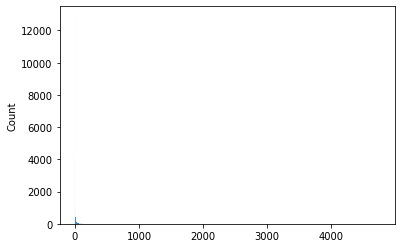

In [8]:
import seaborn as sns

countList = [len(users) for item, users in userPerItem.items()]

sns.histplot(countList);

In [9]:
testID = 'N39317'
userID = 'U91836'
similarity(testID, userID)


0.6666666666666666

In [10]:
testset = [(uid, nid, label) for uid, items in interactions['test'].items() for nid, label in items]
sims = []
for user, test, label in testset:
    sims.append(similarity(test, user))


In [11]:
labels = [tup[2] for tup in testset]

In [13]:
result = pd.DataFrame({'sim': sims, 'label': labels})

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 12))

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

(0.0, 0.1)

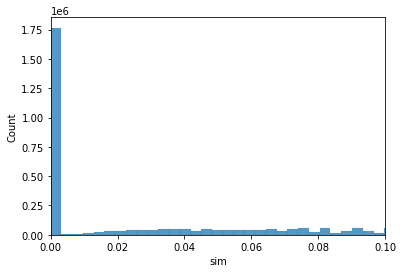

In [20]:
sns.histplot(result['sim'])
plt.xlim(0, 0.1)

(0.0, 60000.0)

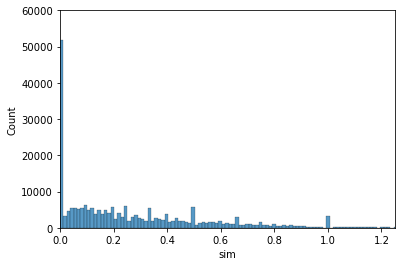

In [176]:
sns.histplot(result[result['label'] == 1]['sim'])
plt.xlim(0, 1.25)
plt.ylim(0, 60000)

(0.0, 60000.0)

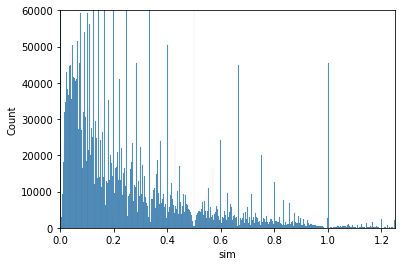

In [177]:
sns.histplot(result[result['label'] == 0]['sim'])
plt.xlim(0, 1.25)
plt.ylim(0, 60000)

In [180]:
np.mean(np.array(sims) == 0)

0.30221663799635967

In [21]:
similarity_threshold = 0.01
result['predicted_label'] = result['sim'] > similarity_threshold

accuracy = (result['predicted_label'] == result['label']).mean()

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Reverse Accuracy: {(1-accuracy) * 100:.2f}%")

Accuracy: 32.76%
Reverse Accuracy: 67.24%
